In [17]:
#pemodelan
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [18]:
dataset = pd.read_csv('dataset\dataset-shopee-final.csv')
dataset.head()

,Date,userName,Rating,Review Text,cleaning,case_folding,normalisasi,tokenize,stopword_removal,stemming,final_text,sentiment
0,2025-06-09 12:20:19,Pengguna Google,5,Jelas dan Terpercaya 💯,Jelas dan Terpercaya,jelas dan terpercaya,jelas dan terpercaya,"['jelas', 'dan', 'terpercaya']",['terpercaya'],['percaya'],percaya,Positif
1,2025-06-16 01:14:54,Pengguna Google,5,"belanja di shopee sangat puas, beda dengan apl...",belanja di shopee sangat puas beda dengan apl...,belanja di shopee sangat puas beda dengan apl...,belanja di shopee sangat puas beda dengan apli...,"['belanja', 'di', 'shopee', 'sangat', 'puas', ...","['belanja', 'shopee', 'puas', 'beda', 'aplikas...","['belanja', 'shopee', 'puas', 'beda', 'aplikas...",belanja shopee puas beda aplikasi belah malal ...,Negatif
2,2025-06-11 19:31:48,Pengguna Google,4,kadang pesanan gak sesuai ekspetasi,kadang pesanan gak sesuai ekspetasi,kadang pesanan gak sesuai ekspetasi,kadang pesanan tidak sesuai ekspetasi,"['kadang', 'pesanan', 'tidak', 'sesuai', 'eksp...","['kadang', 'pesanan', 'sesuai', 'ekspetasi']","['kadang', 'pesan', 'sesuai', 'ekspetasi']",kadang pesan sesuai ekspetasi,Positif
3,2025-06-16 14:19:01,Pengguna Google,2,suka eror,suka eror,suka eror,suka eror,"['suka', 'eror']","['suka', 'eror']","['suka', 'eror']",suka eror,Negatif
4,2025-06-16 17:13:16,Pengguna Google,5,Shopee mantapp selalu memudah kaan kita,Shopee mantapp selalu memudah kaan kita,shopee mantapp selalu memudah kaan kita,shopee mantap selalu memudah kan kita,"['shopee', 'mantap', 'selalu', 'memudah', 'kan...","['shopee', 'mantap', 'memudah']","['shopee', 'mantap', 'mudah']",shopee mantap mudah,Positif


In [19]:
#split dataset menjadi data latih dan data uji
from sklearn.model_selection import train_test_split
x = dataset['final_text']
y = dataset['sentiment']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [20]:
!pip install gensim

In [21]:
from gensim.models import Word2Vec
import numpy as np

# pastikan x_train dan x_test berupa list of list (tokenized)
x_train_tokens = dataset.loc[y_train.index, 'tokenize']
x_test_tokens = dataset.loc[y_test.index, 'tokenize']

# train Word2Vec
w2v_model = Word2Vec(sentences=x_train_tokens, vector_size=100, window=5, min_count=1, workers=4, seed=0)

def document_vector(tokens, model):
    # ambil vektor untuk setiap token, lalu rata-rata
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# transformasi x_train dan x_test ke vektor
x_train_w2v = np.vstack([document_vector(tokens, w2v_model) for tokens in x_train_tokens])
x_test_w2v = np.vstack([document_vector(tokens, w2v_model) for tokens in x_test_tokens])

In [22]:
#menggunakan algoritma Random Forest
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100, random_state=0)
rfc.fit(x_train_w2v, y_train)

RandomForestClassifier(random_state=0)

In [23]:
#model evaluation
y_pred_rfc = rfc.predict(x_test_w2v)

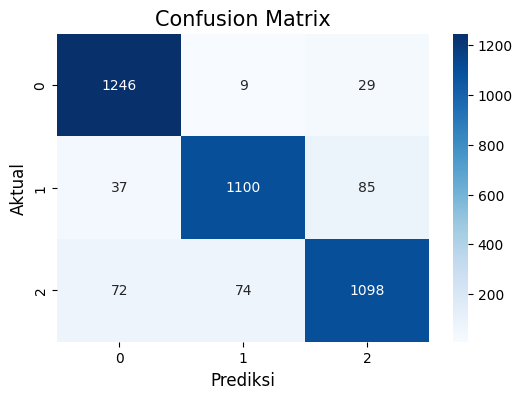

In [24]:
#confussion matrix
cm_rfc = confusion_matrix(y_test, y_pred_rfc)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rfc, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prediksi', fontsize=12)
plt.ylabel('Aktual', fontsize=12)
plt.title('Confusion Matrix', fontsize=15)
plt.show()

In [25]:
#accuracy
accuracy_rfc = accuracy_score(y_test, y_pred_rfc)
print(f'Akurasi:' ,accuracy_rfc)

#classification report
print("Classification Report")
print(classification_report(y_test, y_pred_rfc))

Akurasi: 0.9184
Classification Report
              precision    recall  f1-score   support

     Negatif       0.92      0.97      0.94      1284
      Netral       0.93      0.90      0.91      1222
     Positif       0.91      0.88      0.89      1244

    accuracy                           0.92      3750
   macro avg       0.92      0.92      0.92      3750
weighted avg       0.92      0.92      0.92      3750



In [26]:
#save the model
import joblib
joblib.dump(rfc, 'random_forest_model.pkl')


['random_forest_model.pkl']

In [34]:
import re
import joblib
# Load model yang sudah di-save
rfc_loaded = joblib.load('models/random_forest_model.pkl')

# inference test
def predict_sentiment(text):
    # Tokenisasi sesuai pipeline sebelumnya
    tokens = re.findall(r'\w+', text.lower())
    # Dapatkan vektor dokumen dengan word2vec
    vector = document_vector(tokens, w2v_model).reshape(1, -1)
    prediction = rfc_loaded.predict(vector)
    return prediction[0]

text = "saya sangat suka aplikasi ini, sangat membantu"
predicted_sentiment = predict_sentiment(text)
print(f'Teks: "{text}"\nPrediksi Sentimen: {predicted_sentiment}')

Teks: "saya sangat suka aplikasi ini, sangat membantu"
Prediksi Sentimen: Netral
